In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.random as random
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax.example_libraries import optimizers

import neural_tangents as nt
from neural_tangents import stax

from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization.utils import gegenbauer

from matplotlib.cm import get_cmap
plt.rcParams.update({'font.size': 14})
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors 
savedir = "/n/holyscratch01/pehlevan_lab/Lab/aatanasov/"
figdir = "figures/"


In [3]:
print(jax.devices())

[GpuDevice(id=0, process_index=0), GpuDevice(id=1, process_index=0)]


In [4]:
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / np.outer(np.linalg.norm(x0, axis=1), np.ones(dim))
  return jnp.array(x)

def pure_target_fn(X, beta, k):
  dim = len(beta)
  z = np.dot(X, beta)
  y = gegenbauer.gegenbauer(z, k+1, dim)[k,:]
  return jnp.array(y)[:, jnp.newaxis]

def generate_train_data(p, beta, k, key):
  emp_dim = 100
  dim = len(beta)
  key, emp_key = random.split(key)
  X = generate_synth_data(p, dim, key)
  y = pure_target_fn(X, beta, k)
  return X, y

def format_ps(pvals):
  result = np.zeros(len(pvals), dtype=int)
  for i, p in enumerate(pvals):
    if p < 10:
      result[i] = p + (p % 2)
    elif p < 300:
      result[i] = p + 10 - (p % 10)
    elif p < 3000:
      result[i] = p + 100 - (p % 100)
    else:
      result[i] = p + 1000 - p % 1000
  return result     

from functools import partial
from jax import jvp, grad, jit
# from jax.tree_util import tree_multimap
# from jax import jvp, grad, jit


# @partial(partial, tree_multimap)
# def norm(x, y):
#   return np.sum((x - y) ** 2)  # actually a _squared_ norm ;)

def param_dist(params0, paramsf):
  diff = norm(list(params0), list(paramsf))  
  return jnp.sum(jnp.array(jax.tree_util.tree_leaves(diff)))

def param_diff(params0, paramsf):
  return jax.tree_map(lambda x, y: y-x, params0, paramsf)

def jacobian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  return jvp(f0, [params0], [deltaparams])[1]

def hessian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  df0 = lambda params: jvp(f0, [params], [deltaparams])[1]
  return jvp(df0, [params0], [deltaparams])[1]

import neural_tangents as nt
from neural_tangents import stax

# Generate fully connected NN architecture
def fully_connected(num_layers, width, sigma):
  layers = []
  for i in range(num_layers):
    layers += [stax.Dense(width, W_std = sigma, b_std = 0), stax.Relu()]
  layers += [stax.Dense(1, W_std=sigma, b_std=0)] 
  return stax.serial(*layers)

def make_jax(params):
  new_params = []
  for i, layer in enumerate(params):
    new_layer = []
    for wnbs in layer:
      new_wnbs = jnp.array(wnbs)
      new_layer += [new_wnbs]
    new_layer = tuple(new_layer)
    new_params += [new_layer]
  return new_params

In [5]:
num_repeats = 20
num_repeats_ker = num_repeats #150
num_repeats_nn = num_repeats #5
num_iter_nn = int(3e4)
min_loss_nn = 1e-6

## NN Hyperparameters
lr = 0.008   # Only being used with adam
layers = 2   # Hidden layers
depth = layers + 1

# For now we are actually not ensembling
ensemble_size_list = [3]

## Dimension, sample sizes, max eigenvalue mode to generate data
dim = 10
num_p = 15
num_n = 5
logpmin = .5
lognmin = 1.5
logpmax = np.log10(10000-1)
lognmax = np.log10(1000)
p_test = 2000
kmax = 200

num_repeats_eNTK = num_repeats_ker
ensemble_size = 1

# This is the sweep that we are going to be doing:
pvals = np.logspace(logpmin, logpmax, num=num_p).astype('int')
nvals = np.logspace(lognmin, lognmax, num=num_n).astype('int')
pvals = format_ps(pvals)

In [15]:
k = 2
# Random keys
# init_key = random.PRNGKey(i_key)
# init_keys = random.split(init_key, max(num_repeats_nn, num_repeats_ker))

# Crucially independent test key!! 
test_key = random.PRNGKey(0)
beta_key, const_key, test_key = random.split(test_key, 3)

# Data:
train_sets = []
for d_key in range(20):
  print(f"d = {d_key}", end="\r")
  data_key = random.PRNGKey(d_key)
  train_key = random.split(data_key, len(pvals))
  beta = generate_synth_data(1, dim, beta_key)[0,:]
  y_const = np.sqrt(np.mean((generate_train_data(1000, beta, k, const_key)[1])**2))
  Xs_train = []; ys_train = []
  for i, p in enumerate(pvals):
    X_train, y_train = generate_train_data(p, beta, k, train_key[i])
    y_train = y_train/y_const
    Xs_train += [X_train]
    ys_train += [y_train]
  train_sets += [(Xs_train, ys_train)]

X_test, y_test = generate_train_data(p_test, beta, k, test_key)
y_test = y_test/y_const
test_set = (X_test, y_test)


sigmas = [0.1, 0.5, 1.0, 10.0, 20]
widths = nvals
numK = 3
numS = len(sigmas)
numN = len(widths)

numP = len(pvals)
numE = 20
numD = 20
P_test = 2000

NTK_errs = np.zeros(shape=(numS, numP, numD)) 
eNTK0_errs = np.zeros(shape=(numS, numN, numP, numE, numD)) 
yhats_eNTK0 = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
eNTKf_errs = np.zeros(shape=(numS, numN, numP, numE, numD)) 
yhats_eNTKf = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
NN_errs = np.zeros(shape=(numS, numN, numP, numE, numD))
yhats_NN = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
eNTK0_err_rat = np.zeros(shape=(numS, numN, numP, numE, numD))
NN_err_rat = np.zeros(shape=(numS, numN, numP, numE, numD))



for d in range(20):
  print(f"d = {d}")
  for i, sigma in enumerate(sigmas):
    try: NTK_errs[i, :, d] = np.load(savedir+"inf_err_L={}_k={}_s={:.2f}_d={}.npy".format(depth, k, sigma, d))
    except: print(f"NTK error at sigma={sigma} d={d}")
    for j, width in enumerate(widths):    
      try: 
        NN_errs[i, j, :, :, d] = np.load(savedir+"gen_err_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        yhats_NN[i, j, :, :, d, :, :] = np.load(savedir+"yhats_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))      
      except FileNotFoundError as e: print(f"NN error at width={width}, sigma={sigma} d={d}")
      try: 
        eNTK0_errs[i, j, :, :, d] = np.load(savedir+"gen_err_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        yhats_eNTK0[i, j, :, :, d, :, :] = np.load(savedir+"yhats_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
      except FileNotFoundError as e: print(f"eNTK0 error at width={width}, sigma={sigma} d={d}")
      try: 
        eNTKf_errs[i, j, :, :, d] = np.load(savedir+"gen_err_eNTKf_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        yhats_eNTKf[i, j, :, :, d, :, :] = np.load(savedir+"yhats_eNTKf_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
      except FileNotFoundError as e: print(f"eNTKf error at width={width}, sigma={sigma} d={d}")

        

d = 09
d = 1
d = 2
d = 3
d = 4
eNTK0 error at width=31, sigma=10.0 d=4
eNTKf error at width=31, sigma=10.0 d=4
NN error at width=74, sigma=10.0 d=4
eNTK0 error at width=74, sigma=10.0 d=4
eNTKf error at width=74, sigma=10.0 d=4
NN error at width=177, sigma=10.0 d=4
eNTK0 error at width=177, sigma=10.0 d=4
eNTKf error at width=177, sigma=10.0 d=4
NN error at width=421, sigma=10.0 d=4
eNTK0 error at width=421, sigma=10.0 d=4
eNTKf error at width=421, sigma=10.0 d=4
NN error at width=1000, sigma=10.0 d=4
eNTK0 error at width=1000, sigma=10.0 d=4
eNTKf error at width=1000, sigma=10.0 d=4
d = 5
eNTK0 error at width=1000, sigma=10.0 d=5
eNTKf error at width=1000, sigma=10.0 d=5
d = 6
eNTK0 error at width=1000, sigma=0.5 d=6
eNTKf error at width=1000, sigma=0.5 d=6
d = 7
d = 8
d = 9
d = 10
d = 11
d = 12
d = 13
eNTK0 error at width=31, sigma=1.0 d=13
eNTKf error at width=31, sigma=1.0 d=13
NN error at width=74, sigma=1.0 d=13
eNTK0 error at width=74, sigma=1.0 d=13
eNTKf error at width=74, sig

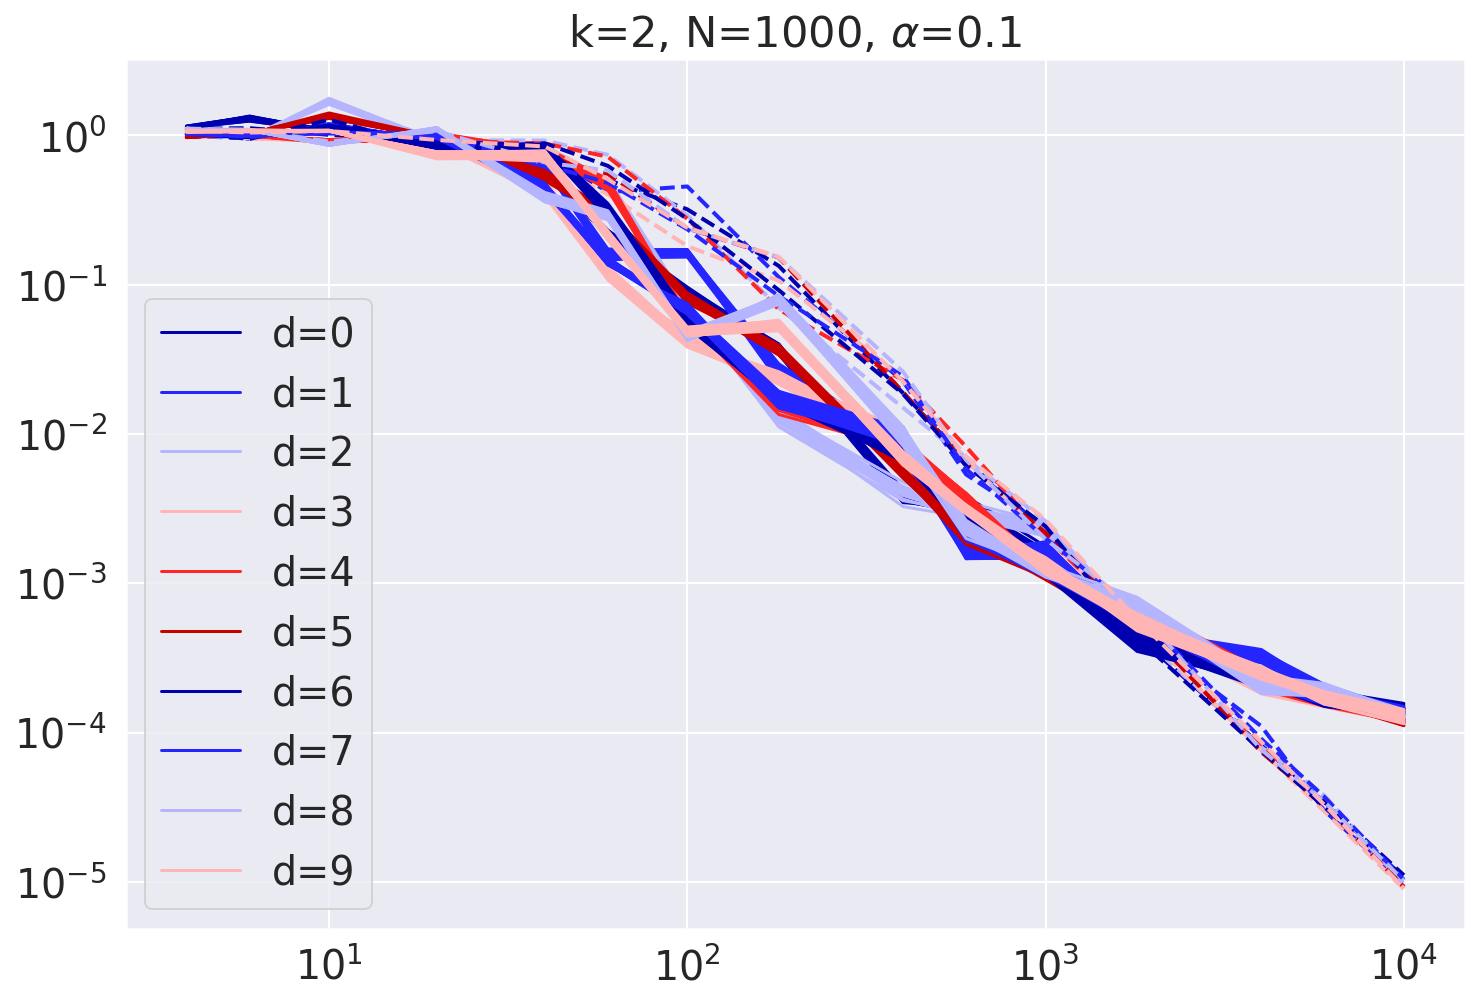

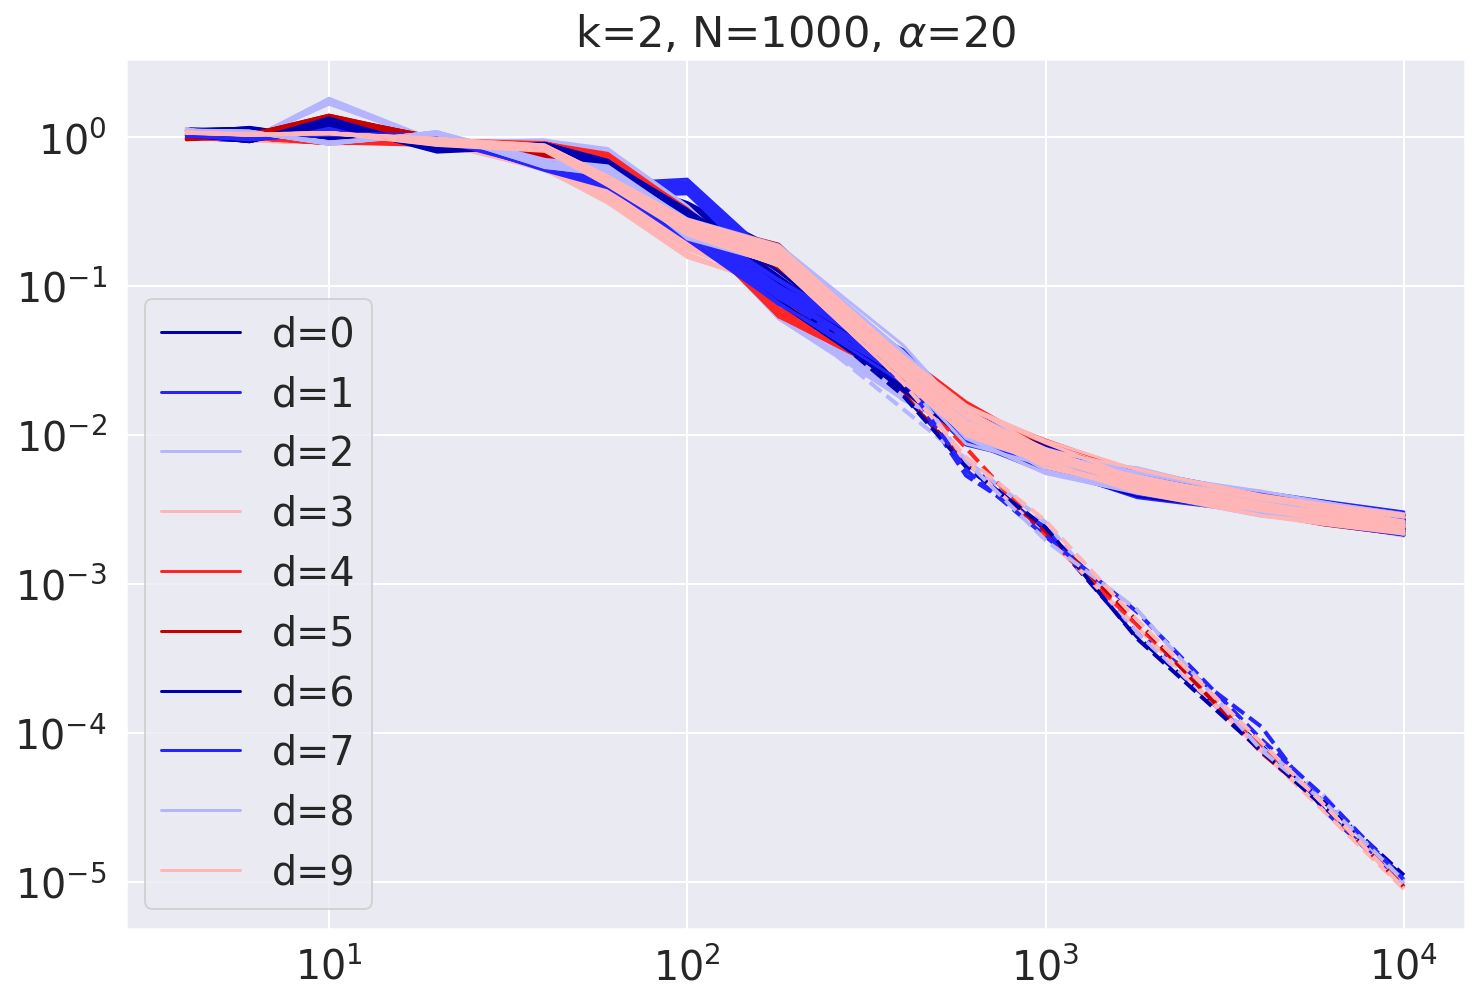

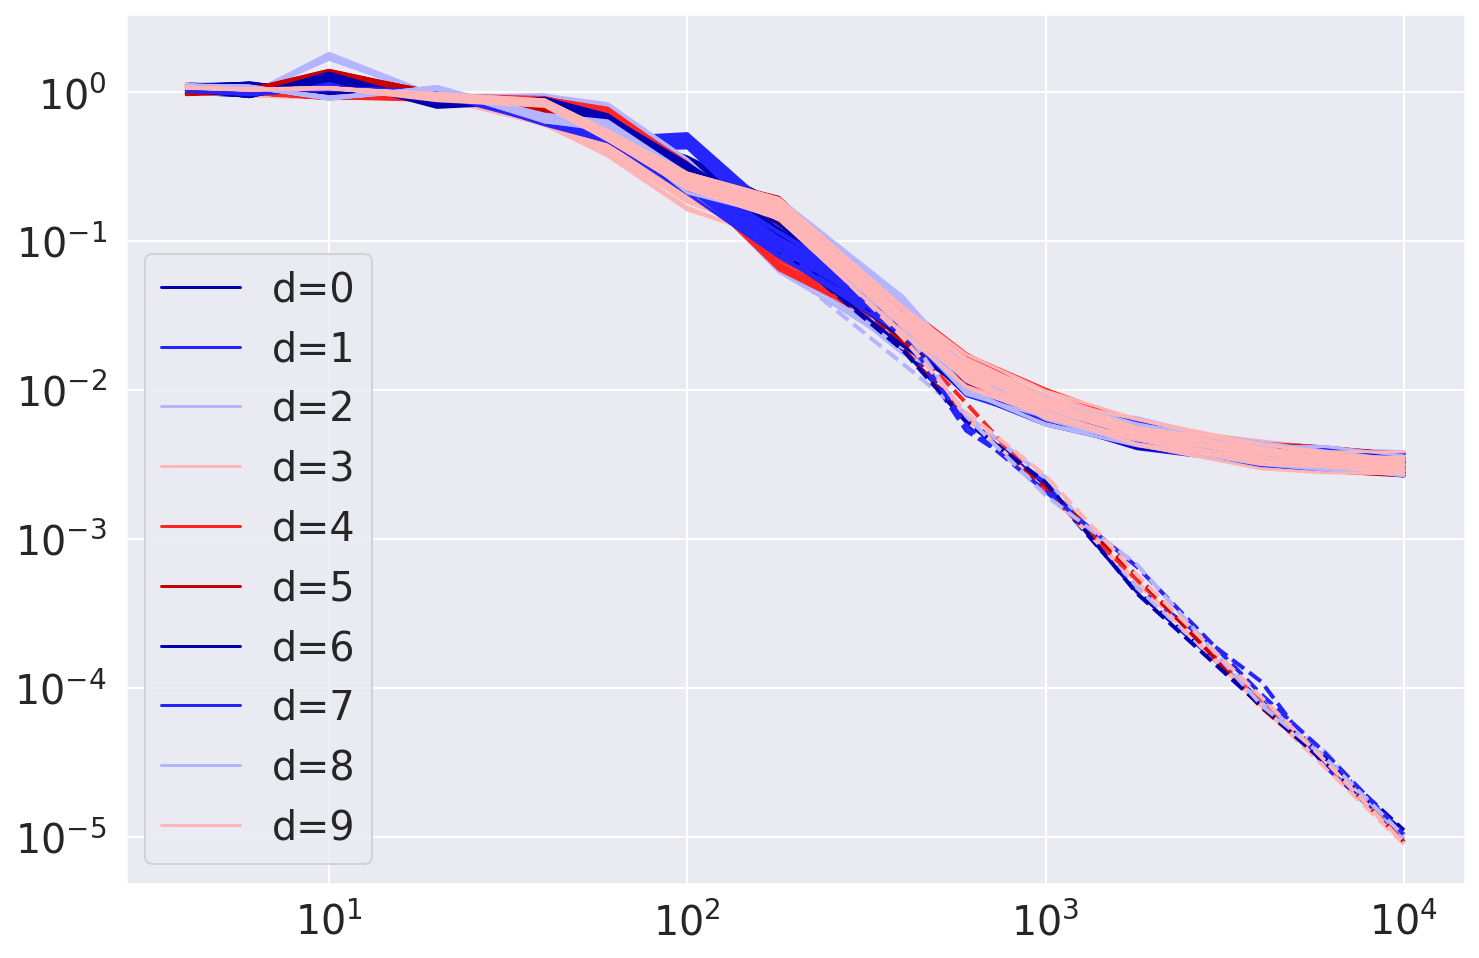

In [16]:
plt.figure(figsize=(12, 8))
nidx=-1
sidx=0
for d in range(numD//2):
  plt.loglog(pvals, NTK_errs[sidx, :, d], f'C{d}--', linewidth=2)
  plt.loglog(pvals, NN_errs[sidx, nidx, :, 0, d], f'C{d}', label=f"d={d}")
  for e in range(1, numE):
    plt.loglog(pvals, NN_errs[sidx, nidx, :, e, d], f'C{d}')
plt.legend()
plt.title(f"k={k}, N={nvals[nidx]}, $\\alpha$={sigmas[sidx]}")

plt.figure(figsize=(12, 8))
sidx=-1
for d in range(numD//2):
  plt.loglog(pvals, NTK_errs[sidx, :, d], f'C{d}--', linewidth=2)
  plt.loglog(pvals, NN_errs[sidx, nidx, :, 0, d], f'C{d}', label=f"d={d}")
  for e in range(1, numE):
    plt.loglog(pvals, NN_errs[sidx, nidx, :, e, d], f'C{d}')
plt.legend()
plt.title(f"k={k}, N={nvals[nidx]}, $\\alpha$={sigmas[sidx]}")

plt.figure(figsize=(12, 8))
for d in range(numD//2):
  plt.loglog(pvals, NTK_errs[-1, :, d], f'C{d}--', linewidth=2)
  plt.loglog(pvals, eNTK0_errs[0, nidx, :, 0, d], f'C{d}', label=f"d={d}")
  for e in range(1, numE):
    plt.loglog(pvals, eNTK0_errs[0, nidx, :, e, d], f'C{d}')
plt.legend()

In [18]:
def zero_to_nan(d):
    array = np.array(d)
    array[array == 0] = np.NaN
    return array

NTK_errs = zero_to_nan(NTK_errs)
eNTK0_errs = zero_to_nan(eNTK0_errs)
eNTKf_errs = zero_to_nan(eNTKf_errs)
NN_errs = zero_to_nan(NN_errs);
yhats_eNTK0 = zero_to_nan(yhats_eNTK0)
yhats_NN = zero_to_nan(yhats_NN);

In [9]:
import seaborn as sns
sns.set(font_scale=1.8)
sns.set_style("darkgrid")
sns.set_palette("seismic")


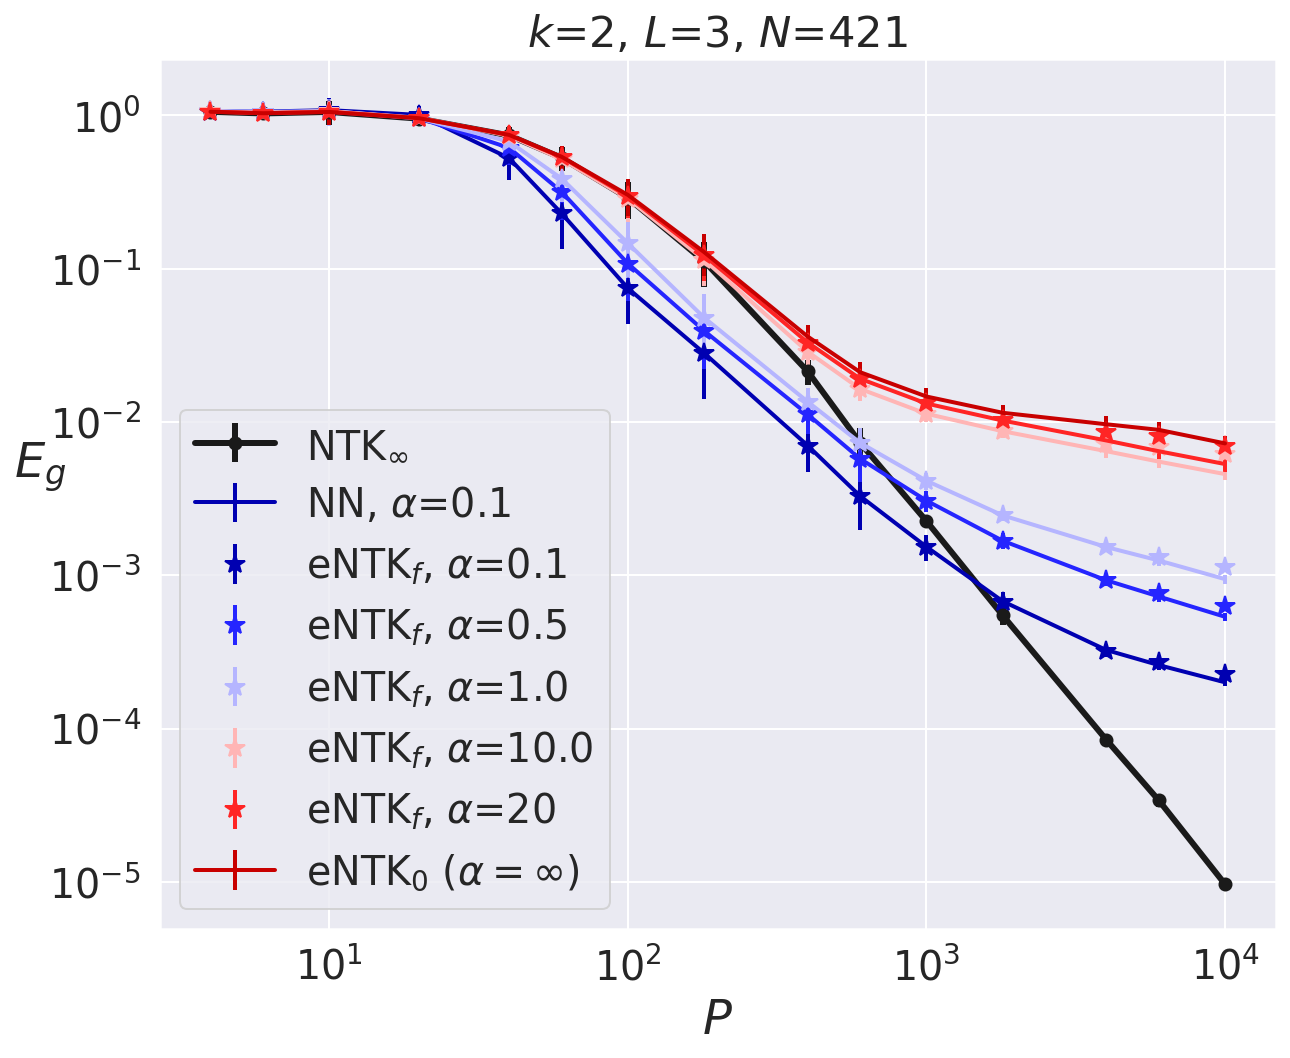

In [19]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
nidx=-2

ax.errorbar(pvals, np.nanmean(NTK_errs[-1, :, :], axis=-1), np.nanstd(NTK_errs[-1, :, :], axis=-1), c='k', fmt='o-', linewidth=3, label=f"NTK$_\infty$")

for i, sigma in enumerate(sigmas):
  if i == 0:
    ax.errorbar(pvals, np.nanmean(NN_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(NN_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='-', linewidth=2, c=f"C{i}", label=f"NN, $\\alpha$={sigma}")
    ax.errorbar(pvals, np.nanmean(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='*', linewidth=2, markersize=10, label=f"eNTK$_f$, $\\alpha$={sigma}", c=f"C{i}")
  else:
    ax.errorbar(pvals, np.nanmean(NN_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(NN_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='-', linewidth=2, c=f"C{i}")
    ax.errorbar(pvals, np.nanmean(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='*', linewidth=2, markersize=10, label=f"eNTK$_f$, $\\alpha$={sigma}", c=f"C{i}")
    
  
ax.errorbar(pvals, np.nanmean(eNTK0_errs[0, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTK0_errs[0, nidx, :, :, :], axis=(-2, -1)), fmt='-', linewidth=2, label=f"eNTK$_0$ ($\\alpha=\infty$)", c=f"C{i+1}")



ax.set_xscale("log")
ax.set_yscale("log")

N = widths[nidx]

plt.title(f"$k$={k}, $L$={depth}, $N$={N}")
plt.xlabel("$P$", fontsize=24)
plt.ylabel("$E_g$", fontsize=24, rotation=0)
plt.legend()
plt.savefig(f"figures/K_f_ReLU_L={depth}_k={k}_N={N}.pdf")

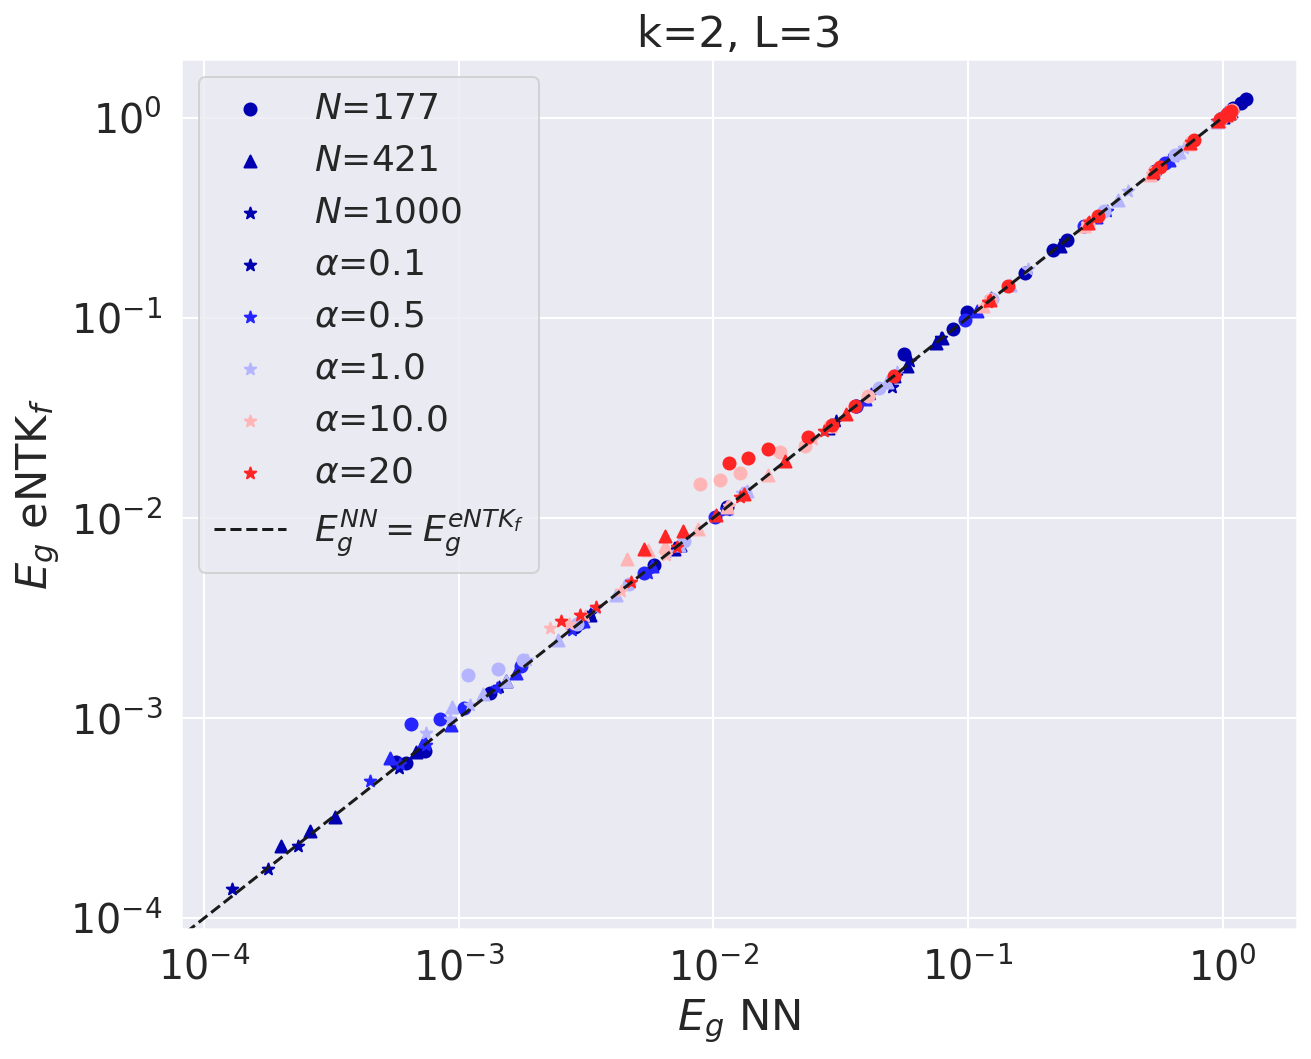

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

plt.title(f"k={k}, L={depth}")
mkrs = ["o", "^", "*"]

i, sigma = 0, sigmas[0]
for j, width in enumerate(widths):
  if j < 2: continue
  ax.scatter(np.log(np.nanmean(NN_errs[i, j, :, :, :], axis=(-2, -1))), np.log(np.nanmean(eNTKf_errs[i, j, :, :, :], axis=(-2, -1))), marker=mkrs[j-2], label=f"$N$={width}", c=f"C{i}")

for i, sigma in enumerate(sigmas):
  for j, width in enumerate(widths):
    if j < 2: continue
    if j == 4:
      ax.scatter(np.nanmean(NN_errs[i, j, :, :, :], axis=(-2, -1)), np.nanmean(eNTKf_errs[i, j, :, :, :], axis=(-2, -1)), marker=mkrs[j-2], label=f"$\\alpha$={sigma}", c=f"C{i}")
    else:
      ax.scatter(np.nanmean(NN_errs[i, j, :, :, :], axis=(-2, -1)), np.nanmean(eNTKf_errs[i, j, :, :, :], axis=(-2, -1)), marker=mkrs[j-2], c=f"C{i}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(np.linspace(-10, 1), np.linspace(-10, 1), 'k--', label="$E_g^{{NN}}= E_g^{{eNTK_f}}$")
plt.legend(loc=2, prop={'size': 18})
  
plt.xlabel("$E_g$ NN")
plt.ylabel("$E_g$ eNTK$_f$")
plt.savefig(f"figures/NN_eNTKf_L={depth}_k={k}.pdf")

<ipython-input-142-9f5c827736fd>:12: RuntimeWarning: Mean of empty slice
  ax.errorbar(pvals, np.nanmean(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='*', linewidth=2, c=f"C{nidx}")
/n/home00/aatanasov/.conda/envs/ffcv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-142-9f5c827736fd>:12: RuntimeWarning: Mean of empty slice
  ax.errorbar(pvals, np.nanmean(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='*', linewidth=2, c=f"C{nidx}")
/n/home00/aatanasov/.conda/envs/ffcv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


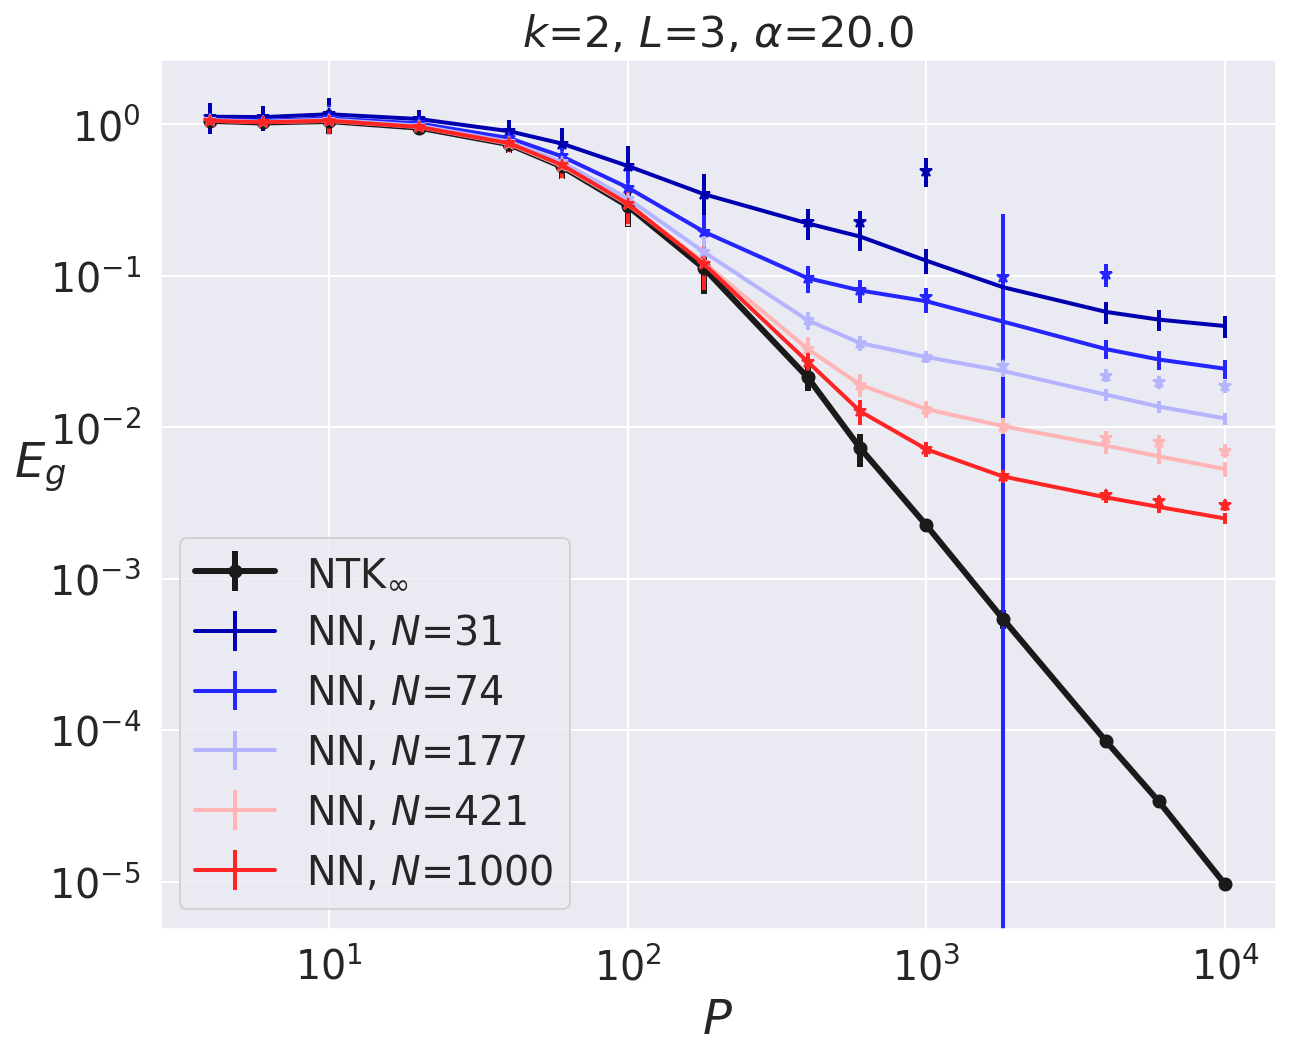

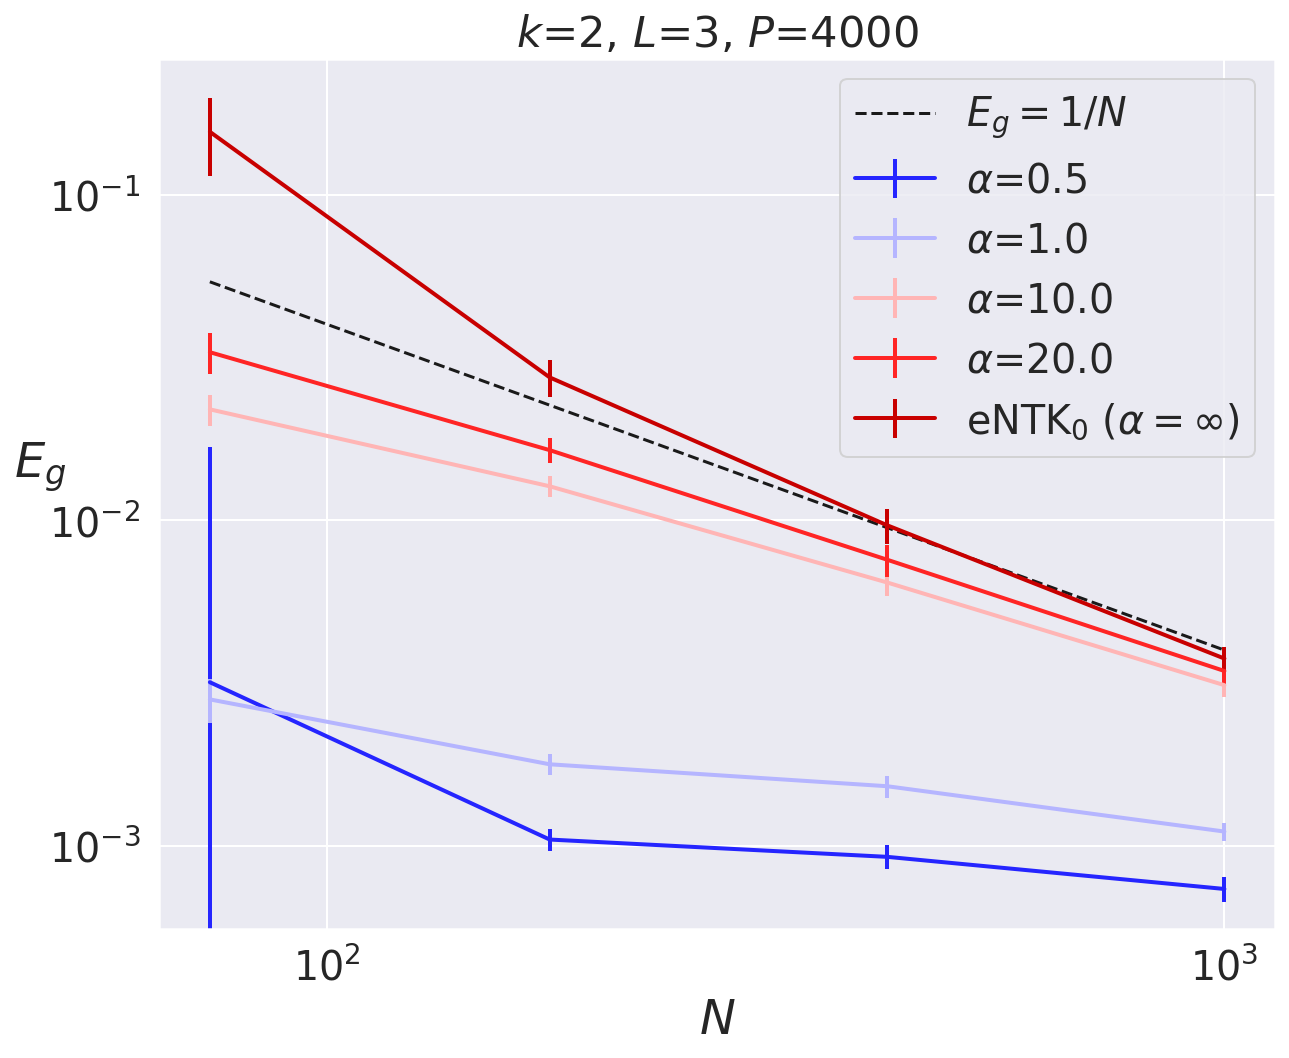

In [142]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
nidx=-2

ax.errorbar(pvals, np.nanmean(NTK_errs[-1, :, :], axis=-1), np.nanstd(NTK_errs[-1, :, :], axis=-1), c='k', fmt='o-', linewidth=3, label=f"NTK$_\infty$")

i, sigma = -1, sigmas[-1]

for nidx, width in enumerate(widths):
  if nidx < 0: continue
  ax.errorbar(pvals, np.nanmean(NN_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(NN_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='-', linewidth=2, c=f"C{nidx}", label=f"NN, $N$={width}")
  ax.errorbar(pvals, np.nanmean(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTKf_errs[i, nidx, :, :, :], axis=(-2, -1)), fmt='*', linewidth=2, c=f"C{nidx}")
  
# ax.errorbar(pvals, np.nanmean(eNTK0_errs[0, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTK0_errs[0, nidx, :, :, :], axis=(-2, -1)), fmt='-', linewidth=2, label=f"eNTK$_0$ ($\\alpha=\infty$)", c=f"C{i+1}")

ax.set_xscale("log")
ax.set_yscale("log")

N = widths[nidx]

plt.title(f"$k$={k}, $L$={depth}, $\\alpha$={sigma}")
plt.xlabel("$P$", fontsize=24)
plt.ylabel("$E_g$", fontsize=24, rotation=0)
plt.legend()
plt.savefig(f"figures/N_sweep_L={depth}_k={k}_s={sigma}.pdf")


fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
nidx=-2

# ax.errorbar(pvals, np.nanmean(NTK_errs[-1, :, :], axis=-1), np.nanstd(NTK_errs[-1, :, :], axis=-1), c='k', fmt='o-', linewidth=3, label=f"NTK$_\infty$")

i, sigma = -1, sigmas[-1]

# for nidx, width in enumerate(widths):
#   if nidx < 0: continue
for i, sigma in enumerate(sigmas):
  if i < 1: continue
  ax.errorbar(widths[1:], np.nanmean(NN_errs[i, 1:, -3, :, :], axis=(-2, -1)), np.nanstd(NN_errs[i, 1:, -3, :, :], axis=(-2, -1)), fmt='-', linewidth=2, label=f"$\\alpha$={sigma}", c=f"C{i}")
ax.plot(widths[1:], 4.0/np.array(widths[1:]), 'k--', label="$E_g = 1/N$")
plt.title("")
  
ax.errorbar(widths[1:], np.nanmean(eNTK0_errs[-1, 1:, -3, :, :], axis=(-2, -1)), np.nanstd(eNTK0_errs[-1, 1:, -3, :, :], axis=(-2, -1)), fmt='-', linewidth=2, label=f"eNTK$_0$ ($\\alpha=\infty$)", c=f"C{i+1}")

ax.set_xscale("log")
ax.set_yscale("log")

N = widths[nidx]

plt.title(f"$k$={k}, $L$={depth}, $P$={pvals[-3]}")
plt.xlabel("$N$", fontsize=24)
plt.ylabel("$E_g$", fontsize=24, rotation=0)
plt.legend()
plt.savefig(f"figures/N_scaling_L={depth}_k={k}_s={sigma}.pdf")



<ipython-input-46-e79da8d6a177>:9: RuntimeWarning: Mean of empty slice
  NN_errs_ens = np.nanmean((np.nanmean(yhats_NN[i, nidx, :, :, :, :, 0], axis=1) - y_test[:, 0])**2, axis=-1)
<ipython-input-46-e79da8d6a177>:9: RuntimeWarning: Mean of empty slice
  NN_errs_ens = np.nanmean((np.nanmean(yhats_NN[i, nidx, :, :, :, :, 0], axis=1) - y_test[:, 0])**2, axis=-1)


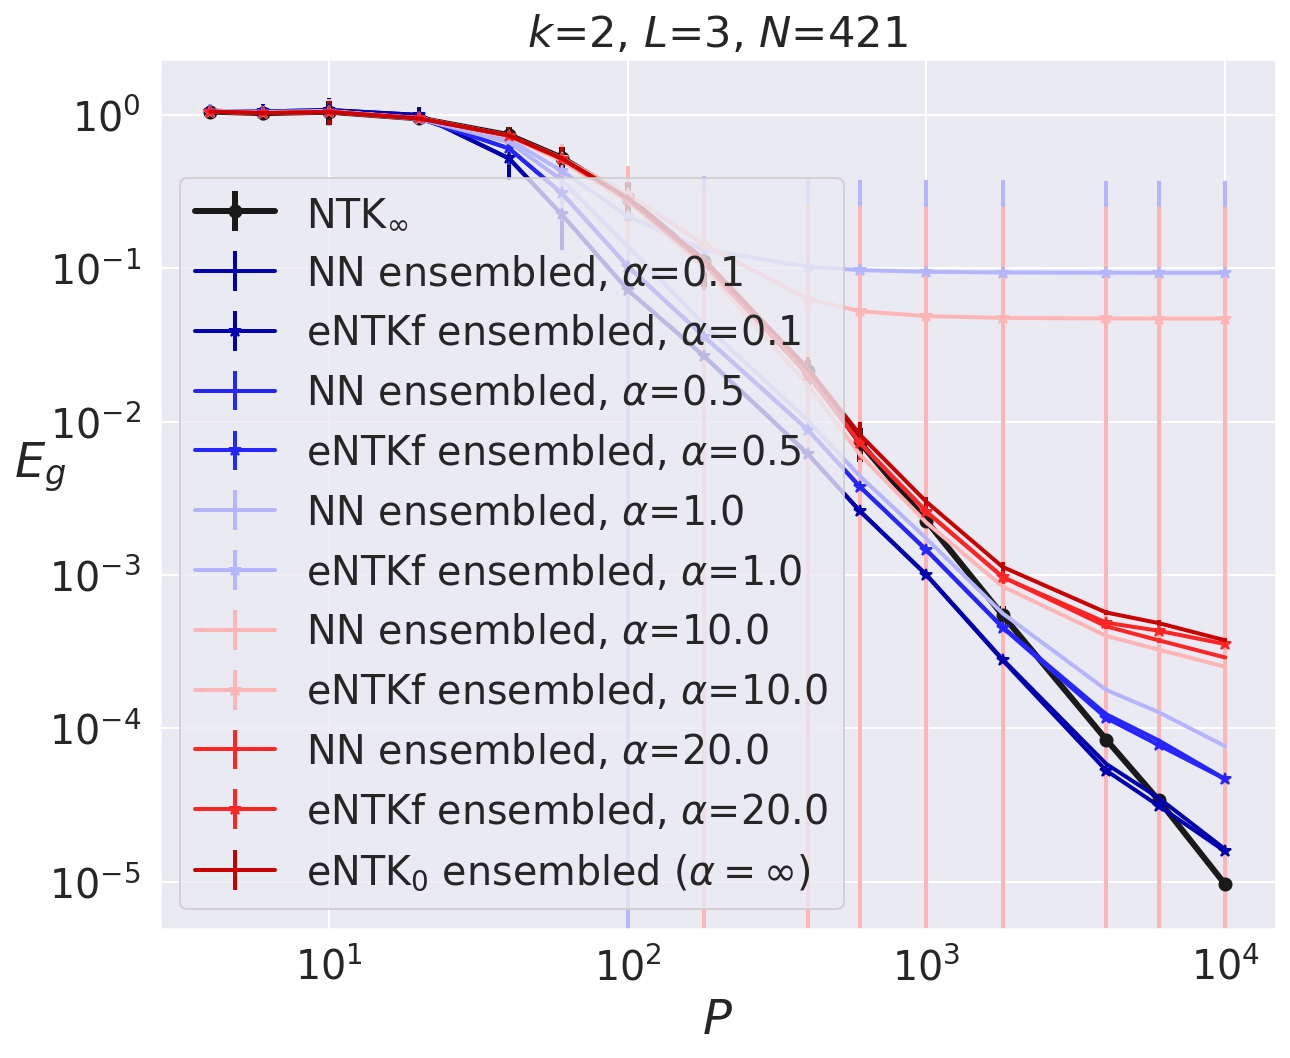

In [46]:
pidx=-1
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.errorbar(pvals, np.nanmean(NTK_errs[-1, :, :], axis=-1), np.nanstd(NTK_errs[-1, :, :], axis=-1), c='k', fmt='o-', linewidth=3, label=f"NTK$_\infty$")
idxs= [0,1,2,3,4]
sigmas = np.array(sigmas)
for i, sigma in zip(idxs, sigmas[idxs]):
  NN_errs_ens = np.nanmean((np.nanmean(yhats_NN[i, nidx, :, :, :, :, 0], axis=1) - y_test[:, 0])**2, axis=-1)
  ax.errorbar(pvals, np.nanmean(NN_errs_ens, axis=-1),  np.nanstd(NN_errs_ens, axis=-1), linewidth=2,fmt='-', label=f"NN ensembled, $\\alpha$={sigma}", c=f"C{i}")
  
  eNTKf_errs_ens = np.nanmean((np.nanmean(yhats_eNTKf[i, nidx, :, :, :, :, 0], axis=1) - y_test[:, 0])**2, axis=-1)
  ax.errorbar(pvals, np.nanmean(eNTKf_errs_ens, axis=-1),  np.nanstd(eNTKf_errs_ens, axis=-1), linewidth=2,fmt='*-', label=f"eNTKf ensembled, $\\alpha$={sigma}", c=f"C{i}")

eNTK0_errs_ens = np.nanmean((np.nanmean(yhats_eNTK0[i, nidx, :, :, :, :, 0], axis=1) - y_test[:, 0])**2, axis=-1)
ax.errorbar(pvals, np.nanmean(eNTK0_errs_ens, axis=-1),  np.nanstd(eNTK0_errs_ens, axis=-1), linewidth=2, fmt='-', label=f"eNTK$_0$ ensembled ($\\alpha=\infty$)", c=f"C{i+1}")
ax.set_xscale("log")
ax.set_yscale("log")

plt.title(f"$k$={k}, $L$={depth}, $N$={N}")
plt.xlabel("$P$", fontsize=24)
plt.ylabel("$E_g$", fontsize=24, rotation=0)
plt.legend()
plt.savefig(f"figures/ReLU_ens_L={depth}_k={k}_N={N}.pdf")